# Before running, follow [this link](https://drive.google.com/drive/folders/1LtBzH3yQi1Hjf9-eybKTz4g9H3fIXlP0?usp=sharing) to upload different maze images to the runtime. Block 4 outputs the solution to the maze.
# Version 1:
Version 1 of this code runs the model and returns the final maze solution. This current file is configured in Version 1 and can be run immediately. The final block of this code is intended only for Version 2, and can be ignored.
# Version 2:
Version 2 is intended to provide better analysis of the algorithm's convergence rate. Version 2 of this file requires you to either download or copy this file so that edits can be made. Then, follow the notes in this file to comment/uncomment Version 1 and Version 2 lines.

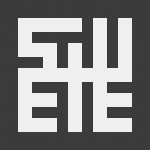

[-100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100]
[-100   -1   -1   -1   -1   -1 -100   -1 -100   -1 -100]
[-100   -1 -100 -100 -100 -100 -100   -1 -100   -1 -100]
[-100   -1   -1   -1 -100   -1 -100   -1 -100   -1 -100]
[-100 -100 -100   -1 -100   -1 -100   -1 -100   -1 -100]
[-100   -1   -1   -1   -1   -1   -1   -1   -1   -1 -100]
[-100   -1 -100 -100 -100   -1 -100   -1 -100 -100 -100]
[-100   -1   -1   -1 -100   -1 -100   -1   -1   -1 -100]
[-100   -1 -100 -100 -100   -1 -100   -1 -100 -100 -100]
[   -100      -1      -1      -1    -100      -1    -100      -1      -1
 1000000    -100]
[-100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100]


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# read in maze image... uploaded from https://drive.google.com/drive/folders/1LtBzH3yQi1Hjf9-eybKTz4g9H3fIXlP0?usp=sharing
maze_img = cv2.imread("maze_1.png", 0)

# define grid dimensions
grid_rows = 11
grid_columns = grid_rows

# display image
cv2_imshow(maze_img)

# create empty 3D NumPy array for grid locations
q_values = np.zeros((grid_rows, grid_columns, 4))

#actions
actions = ['up', 'down', 'left', 'right']

### REWARDS ###
rewards = np.full((grid_rows, grid_columns), -100)

# assign reward values to white spaces
for i in range(grid_columns - 1):
    for j in range(grid_rows - 1):
        x = 12 + (13*i)
        y = 12 + (13*j)
        color = maze_img[x, y]
        if color > 100:
            rewards[i, j] = -1.
# reward for end
rewards[9, 9] = 1000000

for row in rewards:
    print(row)

# See the two notes at the end of this block for toggling Version 1 and Version 2

In [ ]:
from textwrap import shorten
#define a function that determines if the specificed location is a terminal states
def is_terminal_state(current_row_index, current_column_index):
    #if the reward for this location is -1, then it is not a terminal state
    if rewards[current_row_index, current_column_index] == -1.:
        return False
    else:
        return True

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
    #get a random row and column index
    current_row_index = np.random.randint(grid_rows)
    current_column_index = np.random.randint(grid_columns)
    #continue choosing random row and column indexes until a non-terminal state is identified
    while is_terminal_state(current_row_index, current_column_index):
        current_row_index = np.random.randint(grid_rows)
        current_column_index = np.random.randint(grid_columns)
    return current_row_index, current_column_index

def get_next_action(current_row_index, current_column_index):
    #always choose the most promising value from the Q-table for this state
    return np.argmax(q_values [current_row_index, current_column_index])

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
    new_row_index = current_row_index
    new_column_index = current_column_index
    if actions[action_index] == 'up' and current_row_index > 0:
        new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < grid_columns - 1:
        new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < grid_rows - 1:
        new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
        new_column_index -= 1
    return new_row_index, new_column_index



#Define a function that will get the shortest path between any location within
#the warehouse that the robot is allowed to travel and the item packaging location
def get_shortest_path(start_row_index, start_column_index):
    #return immediately if this is an invalid starting location
    if is_terminal_state(start_row_index, start_column_index): #func returns T/F
        return []
    else: #if this is a 'legal' starting location
        reward_total = 0
        current_row_index, current_column_index = start_row_index, start_column_index
        shortest_path = []
        shortest_path.append([current_row_index, current_column_index])
        #continue moving along the path until we reach the goal
        while not is_terminal_state(current_row_index, current_column_index) and reward_total > -120:
            #get the best action to take
            action_index = get_next_action(current_row_index, current_column_index, 1.)
            #move to the next location on the path, and add the new location to the list
            current_row_index, current_column_index = get_next_location(
                                current_row_index,current_column_index, action_index)
            shortest_path.append([current_row_index, current_column_index])
            current_reward = rewards[current_row_index, current_column_index]
            reward_total = reward_total + current_reward

#COMMENT THIS NEXT LINE OUT FOR VERSION 2 OF THE CODE
    return shortest_path

#UNCOMMENT THE REST OF THIS BLOCK FOR VERSION 2 OF THE CODE
    # if reward_total < 0:
    #     return 0
    # else:
    #     return 1


In [ ]:
#define training parameters
discount_factor = 0.9       #discount factor for future rewards
learning_rate = 0.2         #rate at which AI agent should learn

def train_model(num_training_episodes):
    #run through 1000 training episodes
    for episode in range(num_training_episodes):
        #get the starting location for this episode
        row_index, column_index = get_starting_location()

        #continue taking actions until we reach a terminal state
        while not is_terminal_state(row_index, column_index):
            #choose an action
            action_index = get_next_action(row_index, column_index)

            #perform the chosen action, and transition to the next state
            old_row_index, old_column_index = row_index, column_index   #store in old row and column indexes
            row_index, column_index = get_next_location(row_index, column_index, action_index)

            # Choose the next action in the new state
            next_action_index = get_next_action(row_index, column_index)

            #receive the reward for moving to the new state, and calculate the temporal difference
            reward = rewards[row_index, column_index]
            old_q_value = q_values[old_row_index, old_column_index, action_index]
            next_q_value = q_values[row_index, column_index, next_action_index]
            temporal_difference = reward + (discount_factor * next_q_value) - old_q_value

            #update q-value for prvious state and action pair
            new_q_value = old_q_value + (learning_rate *  temporal_difference)
            q_values[old_row_index, old_column_index, action_index] = new_q_value

    # print ('Training complete!')

# For this next block, either run as is for Version 1 OR comment out the first three lines and uncomment the rest of the block for Version 2


In [ ]:
training_episodes = 400
train_model(training_episodes)
print("The solution is: ", get_shortest_path(1,1))

# import matplotlib.pyplot as plt

# tot_episodes = []
# correct_sol_prob = []

# training_episodes = 1  # initialize the training_episodes variable

# for i in range(400):
#     tot_episodes.append(i+1)  # append to the list
#     prob = 0  # initialize probability for each episode
#     for j in range(20):
#         prob += get_shortest_path(1, 1)
#         q_values = np.zeros((grid_rows, grid_columns, 4))
#         train_model(training_episodes)
#     correct_sol_prob.append(prob/20*100)  # calculate average probability and append
#     training_episodes += 1
#     print(i)



The solution is:  [[1, 1], [2, 1], [3, 1], [3, 2], [3, 3], [4, 3], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [6, 7], [7, 7], [8, 7], [9, 7], [9, 8], [9, 9]]


# All blocks beyond this should be uncommented for Version 2 of this file


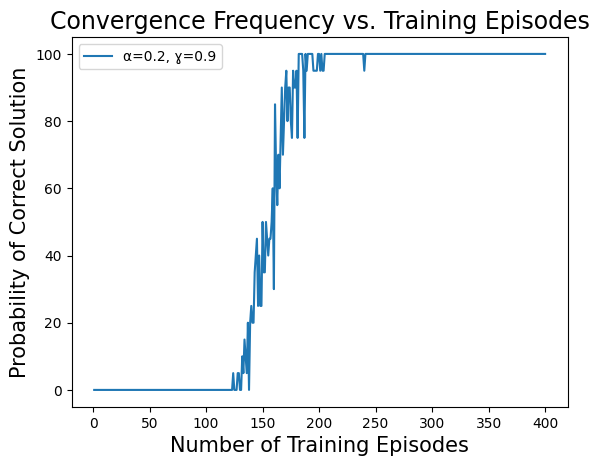

In [ ]:
# label_str = "α={}, ɣ={}".format(learning_rate, discount_factor)
# plt.plot(tot_episodes, correct_sol_prob, label=label_str)
# plt.legend()
# plt.title("Convergence Frequency vs. Training Episodes", fontsize = 17)
# plt.xlabel("Number of Training Episodes", fontsize = 15)
# plt.ylabel("Probability of Correct Solution", fontsize = 15)
# # plt.xlim([0, 600])
# plt.show()  # add this line to display the plot



